<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Steps:" data-toc-modified-id="Steps:-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Steps:</a></span></li><li><span><a href="#General" data-toc-modified-id="General-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>General</a></span></li></ul></li><li><span><a href="#DATA" data-toc-modified-id="DATA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>DATA</a></span><ul class="toc-item"><li><span><a href="#Data-directories" data-toc-modified-id="Data-directories-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data directories</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Define-the-model-layers" data-toc-modified-id="Define-the-model-layers-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Define the model layers</a></span></li><li><span><a href="#Compile-the-model" data-toc-modified-id="Compile-the-model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Compile the model</a></span><ul class="toc-item"><li><span><a href="#Model-summary" data-toc-modified-id="Model-summary-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Model summary</a></span></li><li><span><a href="#Plot-a-graph-of-the-model-architecture" data-toc-modified-id="Plot-a-graph-of-the-model-architecture-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Plot a graph of the model architecture</a></span></li></ul></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#Plot--the-learning-curves" data-toc-modified-id="Plot--the-learning-curves-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Plot  the learning curves</a></span></li><li><span><a href="#Test-model-on-'test'-dataset" data-toc-modified-id="Test-model-on-'test'-dataset-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Test model on <em>'test'</em> dataset</a></span></li></ul></li><li><span><a href="#Dropout" data-toc-modified-id="Dropout-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dropout</a></span></li><li><span><a href="#Augmentation" data-toc-modified-id="Augmentation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Augmentation</a></span></li><li><span><a href="#Transfer-learning" data-toc-modified-id="Transfer-learning-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Transfer learning</a></span></li></ul></div>

# Classification with Convolutional Neural Networks


The aim of this notebook is to showcase in practice - i.e. in code - how to build a simple CNN for the purpose of classifying image data.

The dataset used is intentionally a relatively small dataset, for the sake of time economy, but also in order to reduce the computational resources required.


Remember: https://keras.io is a useful source of information regarding Keras and Tensorflow.


###  Steps:

1) DATA. As a first step we will load the original data and divide the available images into three datasets (training, validation, test). 

2) MODEL. Build the network architecture: this is the part where we put together the code which: describes the neural network, processes the images, and feeds the images into the network for training.

3) LEARNING CURVES. Once the training is finished, plot the performance of the trained model 

4) DROPOUT. A first effort to improve the performance of the model (if we observed overfitting earlier).

5) AUGMENTATION. Another way to improve model accuracy or avoid overfitting

6) TRANSFER LEARNING. 



### General

Let's start by importing **various useful** libraries in one go. 
We also check the versions of keras and tensorflow he have in our disposal (because we can).
If more libraries become needed later on, come back to the cell below and add them here.

In [1]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import os, shutil
from shutil import copyfile
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

print(keras.__version__)
print(tensorflow.__version__)

2.4.0
2.3.1


## DATA


We will use an existing dataset, dowloaded from kaggle (https://www.kaggle.com/alxmamaev/flowers-recognition)

This is a set of images of 5 different types of flowers. 



### Data directories

**Create a hierarchy of directories**, with seperate directories for *training*,  *validation*, and *test* datasets. Each of these will contain a subdirectory for each *class*.

_Important_: __obviously, building the datasets only needs to be done once.__ 

In [2]:
# In the line below define a 'base' name of an existing directory where you want to store 
# the original folder with the images and the datasets you are about to create.
# Something like:  base = '/mnt/ceph/home/r1111683/data'

base='/p/home/jusers/rantsiou1/juwels/data'

In [3]:
# define the directory to store the datasets
classification_data_path=os.path.join(base + '/natural_images_classification') 

# create that directory
if not os.path.exists(classification_data_path):
  os.mkdir(classification_data_path)

# define datasets (i.e. subdirs within the 'base' dir) and define classes (i.e. sub-subdirs for each of the dataset directories)
datasets=['train','validation','test']
classes=['airplane','car','cat','dog','flower','fruit','motorbike','person']

# create that hierarchy of dirs and subdirs
for dtype in datasets:
  path_set=os.path.join(classification_data_path,dtype)
  if not os.path.exists(path_set):
    os.mkdir(path_set)
  for c in classes:
    path_class=os.path.join(path_set,c)
    if not os.path.exists(path_class):
      os.mkdir(path_class)      

In [14]:
# Function  - named 'pop_dirs' - for splitting the data into train, validation, and test data (after shuffling them) 
# and populating the directory tree created above.

def pop_dirs(SOURCE, TRAINING, VALIDATION, TEST, SPLIT_SIZE):
    # create list of all files in the SOURCE directory
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, will skip.")

            
            
    training_length = int(len(files) * SPLIT_SIZE)               
    validation_length = int((len(files) - training_length)/2.0)
    test_length = validation_length
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[training_length:training_length+validation_length]
    test_set = shuffled_set[training_length+validation_length:training_length+validation_length+test_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in validation_set:
        this_file = SOURCE + filename
        destination = VALIDATION + filename
        copyfile(this_file, destination)

    for filename in test_set:
        this_file = SOURCE + filename
        destination = TEST + filename
        copyfile(this_file, destination)

In [15]:
# The actual copying of files from the 'data' folder into the folder hierarchy created earlier. 

j=0
# fraction of data (from 0.0 to 1.0) to be used as training data. The rest will be split equally a
split_size = .75   


for c in classes:

  src_path=os.path.join(base,'natural_images',c)+'/'

  train_path=os.path.join(classification_data_path,'train',c)+'/' 
  validation_path=os.path.join(classification_data_path,'validation',c)+'/'
  test_path=os.path.join(classification_data_path,'test',c)+'/'

  print('Copyting data FROM:')
  print(src_path)
  print('TO:')
  print(train_path)
  print(validation_path)
  print(test_path)
  print('\n')  
    
  pop_dirs(src_path, train_path, validation_path, test_path, split_size)
  j+=1


Copyting data FROM:
/p/home/jusers/rantsiou1/juwels/data/natural_images/airplane/
TO:
/p/home/jusers/rantsiou1/juwels/data/natural_images_classification/train/airplane/
/p/home/jusers/rantsiou1/juwels/data/natural_images_classification/validation/airplane/
/p/home/jusers/rantsiou1/juwels/data/natural_images_classification/test/airplane/


Copyting data FROM:
/p/home/jusers/rantsiou1/juwels/data/natural_images/car/
TO:
/p/home/jusers/rantsiou1/juwels/data/natural_images_classification/train/car/
/p/home/jusers/rantsiou1/juwels/data/natural_images_classification/validation/car/
/p/home/jusers/rantsiou1/juwels/data/natural_images_classification/test/car/


Copyting data FROM:
/p/home/jusers/rantsiou1/juwels/data/natural_images/cat/
TO:
/p/home/jusers/rantsiou1/juwels/data/natural_images_classification/train/cat/
/p/home/jusers/rantsiou1/juwels/data/natural_images_classification/validation/cat/
/p/home/jusers/rantsiou1/juwels/data/natural_images_classification/test/cat/


Copyting data FRO

Check the number of images for each dataset and each class

In [16]:
datasets=['train','validation','test']
classes=['airplane','car','cat','dog','flower','fruit','motorbike','person']

for dset in datasets:
  for c in classes:
    path=os.path.join(base,'natural_images_classification',dset,c)
    print('number of',  dset,  'images in', c,':', len(os.listdir(path)))

number of train images in airplane : 526
number of train images in car : 526
number of train images in cat : 527
number of train images in dog : 526
number of train images in flower : 526
number of train images in fruit : 526
number of train images in motorbike : 526
number of train images in person : 526
number of validation images in airplane : 88
number of validation images in car : 88
number of validation images in cat : 88
number of validation images in dog : 88
number of validation images in flower : 88
number of validation images in fruit : 88
number of validation images in motorbike : 88
number of validation images in person : 88
number of test images in airplane : 88
number of test images in car : 88
number of test images in cat : 88
number of test images in dog : 88
number of test images in flower : 88
number of test images in fruit : 88
number of test images in motorbike : 88
number of test images in person : 88


## Model

This section containes the code for the CNN model

In [48]:
# Run ONLY when clearing of the session is needed

tensorflow.keras.backend.clear_session()

In [4]:
# Place needed and updatable parameters in a dictionary for easy access and change
PARAMS = {'lr': 1e-4, # Learning Rate
          'batch_size': 64,
          'n_epochs': 50,
          'loss': 'categorical_crossentropy',
          'metrics': 'acc', # accuracy
          'image_input_shape' : (100,100,3),
          'save_model' : 'classification_1.h5'
          }

In [20]:
# Use the ImageDataGenerator class from Keras, and its flow_from_directory method to generate shuffled data batches

train_datagen = ImageDataGenerator(rescale = 1.0/255.)#,horizontal_flip=True,zoom_range=0.2,rotation_range=20,width_shift_range=0.1,height_shift_range=0.1)
validation_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train = train_datagen.flow_from_directory(
        classification_data_path+'/train',
        target_size=(100, 100),
        batch_size=PARAMS['batch_size'],
        class_mode='categorical') 

validation = validation_datagen.flow_from_directory(
        classification_data_path+'/validation',
        target_size=(100, 100),
        batch_size=PARAMS['batch_size'],
        class_mode='categorical')


test = test_datagen.flow_from_directory(
        classification_data_path+'/test',
        target_size=(100, 100),
        batch_size=PARAMS['batch_size'],
        class_mode='categorical')

Found 4202 images belonging to 8 classes.
Found 703 images belonging to 8 classes.
Found 704 images belonging to 8 classes.


In [6]:
# Check the sizes of the image and label batches (useful for debugging size errors)
for images_batch, labels_batch in train:
    print('Image batches have shape:', images_batch.shape)
    print('Label batches have shape:', labels_batch.shape)
    break

Image batches have shape: (64, 100, 100, 3)
Label batches have shape: (64, 8)


### Define the model layers


Use Conv2D layers, each of wich will be followed by MaxPooling2D layer. 

- How many Conv2D layers to use? (in this case **3 is a good guess** to start with)
- Number of filters for each? (powers of two typically used, with number of filters typically increassing in deeper layers, i.e. 32,64,128)
- Size of these filters? 3x3, or 5x5, or 7x7 are typical values (start with **3x3**)
- A Flatten layer should be added after the last Conv2D layer 
- Last layer should be a Dense layer with a 'softmax' activation, as we are building a 'classification' model
- It is likely that more Dense layers can be added between the Flatten and the last Dense layer (the classifier).


<font color='blue'> **Task 1:**
+ Build the CNN, by adding the necessary sequence of layers: use what was discussed in the lecture and in the text just above as quide
</font>

In [52]:
# The model layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=PARAMS['image_input_shape']))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(256, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

### Compile the model

In [53]:
model.compile(loss=PARAMS['loss'],
              optimizer=optimizers.Adam(lr=PARAMS['lr']),
              metrics=[PARAMS['metrics']])

#### Model summary

Draw a summary of each layer of the model.

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0

#### Plot a graph of the model architecture

In [11]:
# create a graph of the model layers
from tensorflow.keras.utils import plot_model
!pip install --user pydot
plot_model(model, to_file='model.png',show_shapes=True,rankdir='TB',show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Train the model

In [55]:
# Fit (i.e train) the model 

spe=len(train)   # Steps Per Epoch: train_size/batch_size
epoch_num=PARAMS['n_epochs']
val_steps=len(validation)  # validation_size/batch_size


history = model.fit(
            train,
            steps_per_epoch=spe,  
            epochs=epoch_num,
            validation_data=validation,
            validation_steps=val_steps) 


# To save the output of the model, uncomment the line below.
#model.save(PARAMS['save_model'])

Epoch 1/50
66/66 [==============================] - 5s 81ms/step - loss: 1.3437 - acc: 0.5505 - val_loss: 0.8629 - val_acc: 0.6942
Epoch 2/50
66/66 [==============================] - 5s 77ms/step - loss: 0.6785 - acc: 0.7608 - val_loss: 0.6383 - val_acc: 0.7653
Epoch 3/50
66/66 [==============================] - 5s 81ms/step - loss: 0.5234 - acc: 0.8132 - val_loss: 0.5546 - val_acc: 0.8023
Epoch 4/50
66/66 [==============================] - 5s 78ms/step - loss: 0.4238 - acc: 0.8520 - val_loss: 0.4931 - val_acc: 0.8222
Epoch 5/50
66/66 [==============================] - 5s 77ms/step - loss: 0.3508 - acc: 0.8743 - val_loss: 0.4079 - val_acc: 0.8506
Epoch 6/50
66/66 [==============================] - 5s 76ms/step - loss: 0.3104 - acc: 0.8877 - val_loss: 0.3870 - val_acc: 0.8492
Epoch 7/50
66/66 [==============================] - 5s 78ms/step - loss: 0.2881 - acc: 0.8991 - val_loss: 0.3823 - val_acc: 0.8521
Epoch 8/50
66/66 [==============================] - 5s 80ms/step - loss: 0.2401 - a

### Plot  the learning curves 

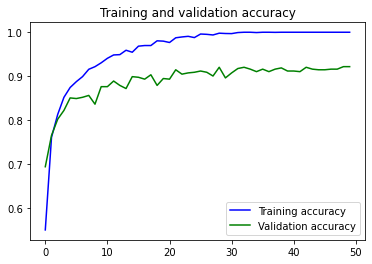

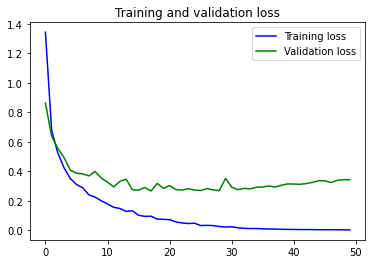

In [56]:
# Check the progress of the training, by plotting the Learning Curves:
# a) Accuracy of the model on the train and validation datasets as a function of epochs (time)
# b) Value of loss function on train and validation datasets as a function of epochs

# if the model was saved from an earlier run, uncomment the line below to load it
#model = load_model('name_of_model_to_load.h5')

epoch_num=PARAMS['n_epochs']
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(range(epoch_num), acc, 'b', label='Training accuracy')
plt.plot(range(epoch_num), val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(epoch_num), loss, 'b', label='Training loss')
plt.plot(range(epoch_num), val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

### Test model on *'test'* dataset

As a final step on checking the performance of the model, we run the trained model on the third dataset, the 'test' dataset. (These are data that our model has not seen yet).


In [57]:
test_score = model.evaluate(test)
print(model.metrics_names)
print(test_score)
print()
print("Accuracy = ",test_score[1]*100,'%')

11/11 [==============================] - 1s 92ms/step - loss: 0.3742 - acc: 0.9105
['loss', 'acc']
[0.3742465674877167, 0.9105113744735718]

Accuracy =  91.05113744735718 %


## Dropout


One way to overcome overfitting of the model is to add one or more Dropout layers in the model.

A 'Dropout' layer will randomly drop-out (i.e. remove) a user-defined number of nodes (i.e. connections) between two layers.

Adding a dropout layer looks like this:
    *model.add(layers.Dropout(0.5))*
The argument of Dropout is a number from 0.0 to 1.0 which corresponds to the fraction of nodes to **remove** . 

A typical value  is around 0.5-0.6 (i.e. 50-60% or the nodes removed).


<font color='blue'>**Task 2**
Add a Dropout Layer (or try adding more that one) in the model you created earlier and train the model again.
    
**NOTE:** 
 + remember to clear the session with the command available at the beginning of Section 2
 + must run again the cell with the model architecture, and compile the model again before fitting the new architecture.   
</font>


In [58]:
# clear the session

### add code here:
tensorflow.keras.backend.clear_session()

In [7]:
# model layers
# use the previous model PLUS a dropout layer


### add code here:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=PARAMS['image_input_shape']))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.6))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

In [8]:
# compile the model

### add code here:
model.compile(loss=PARAMS['loss'],
              optimizer=optimizers.Adam(lr=PARAMS['lr']),
              metrics=[PARAMS['metrics']])


In [9]:
# fit the model
spe=len(train)   # Steps Per Epoch: train_size/batch_size
epoch_num=PARAMS['n_epochs']
val_steps=len(validation)  # validation_size/batch_size

### add code here:
history = model.fit(
            train,
            steps_per_epoch=spe,  
            epochs=epoch_num,
            validation_data=validation,
            validation_steps=val_steps) 


Epoch 1/50
66/66 [==============================] - 20s 308ms/step - loss: 1.4755 - acc: 0.5019 - val_loss: 1.0004 - val_acc: 0.6415
Epoch 2/50
66/66 [==============================] - 6s 85ms/step - loss: 0.7378 - acc: 0.7380 - val_loss: 0.6628 - val_acc: 0.7653
Epoch 3/50
66/66 [==============================] - 6s 85ms/step - loss: 0.5811 - acc: 0.7827 - val_loss: 0.5704 - val_acc: 0.7923
Epoch 4/50
66/66 [==============================] - 5s 79ms/step - loss: 0.4920 - acc: 0.8182 - val_loss: 0.5025 - val_acc: 0.8108
Epoch 5/50
66/66 [==============================] - 5s 75ms/step - loss: 0.4383 - acc: 0.8365 - val_loss: 0.4478 - val_acc: 0.8350
Epoch 6/50
66/66 [==============================] - 5s 76ms/step - loss: 0.3645 - acc: 0.8667 - val_loss: 0.4557 - val_acc: 0.8179
Epoch 7/50
66/66 [==============================] - 5s 79ms/step - loss: 0.3271 - acc: 0.8791 - val_loss: 0.3747 - val_acc: 0.8578
Epoch 8/50
66/66 [==============================] - 5s 75ms/step - loss: 0.3027 -

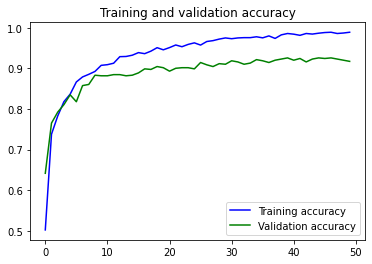

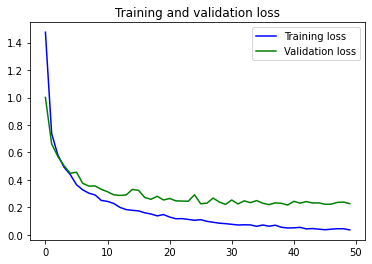

In [10]:
# plot the learning curves

### add code here:

epoch_num=PARAMS['n_epochs']
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(range(epoch_num), acc, 'b', label='Training accuracy')
plt.plot(range(epoch_num), val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(epoch_num), loss, 'b', label='Training loss')
plt.plot(range(epoch_num), val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [11]:
# evaluate model on *test* dataset

### add code here:

test_score = model.evaluate(test)
print(model.metrics_names)
print(test_score)
print()
print("Accuracy = ",test_score[1]*100,'%')

11/11 [==============================] - 2s 225ms/step - loss: 0.2498 - acc: 0.9233
['loss', 'acc']
[0.2497541457414627, 0.9232954382896423]

Accuracy =  92.32954382896423 %


## Augmentation

One possible remedy for overfitting, when it is caused by lack of enough data, is to use data augmentation.
In data augmentation, already existing data - images in our case - are 'tranformed' into new data through some basic transformations like mirroring or flipping, rotation, zoom, rescaling, etc.  of the image.


In Keras, the ImageDataGenerator class, offers an easy way to include these augmentation techniques.
Check the ImageDataGenerator entry here:https://keras.io/api/preprocessing/image/  to see how it is done.

<font color='blue'>**Task 3**
-Based on the Keras link above, choose the augmentation transformations which make sense for the dataset you are using, and implement these transformations within the ImageDataGenerator. You can just edit and run the code we used earlier (3d cell in Section 2) or re-write (copy) that cell here and add the relevant arguments for the image augmentation (transformation).       
**NOTE**: augmentation is applied only on the training dataset   
-Train again the model and plot its performance on the new, augmented dataset.  
-Do not forget to also evaluate the trained model on the 'test' dataset</font>
    
    

In [58]:
# clear the session

### add code here:
tensorflow.keras.backend.clear_session()

In [12]:
# Use the ImageDataGenerator class from Keras, and its flow_from_directory method to create batched of **augmented** data.

### add arguments that define augmentation techniques in the ImageDataGenerator line below

train_datagen = ImageDataGenerator(rescale = 1.0/255.,horizontal_flip=True,zoom_range=0.2,rotation_range=20,width_shift_range=0.1,height_shift_range=0.1)

# this can be left as is
train = train_datagen.flow_from_directory(
        classification_data_path+'/train',
        target_size=(100, 100),
        batch_size=PARAMS['batch_size'],
        class_mode='categorical') 



Found 4202 images belonging to 8 classes.


In [13]:
# use the same model layers which you used the first time (i.e. no dropout layer)

### add code here:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=PARAMS['image_input_shape']))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

In [15]:
# compile model 
model.compile(loss=PARAMS['loss'],
              optimizer=optimizers.Adam(PARAMS['lr']),
              metrics=[PARAMS['metrics']])

In [16]:
# Fit the model 
spe=len(train)   # train_size/batch_size
epoch_num=PARAMS['n_epochs']
val_steps=len(validation)  # validation_size/batch_size


history = model.fit(
            train,
            steps_per_epoch=spe,  
            epochs=epoch_num,
            validation_data=validation,
            validation_steps=val_steps) 

Epoch 1/50
66/66 [==============================] - 14s 210ms/step - loss: 1.4643 - acc: 0.4895 - val_loss: 0.9828 - val_acc: 0.6302
Epoch 2/50
66/66 [==============================] - 11s 167ms/step - loss: 0.9170 - acc: 0.6742 - val_loss: 0.8410 - val_acc: 0.6927
Epoch 3/50
66/66 [==============================] - 11s 168ms/step - loss: 0.7423 - acc: 0.7363 - val_loss: 0.7478 - val_acc: 0.7397
Epoch 4/50
66/66 [==============================] - 11s 173ms/step - loss: 0.6686 - acc: 0.7568 - val_loss: 0.6290 - val_acc: 0.7738
Epoch 5/50
66/66 [==============================] - 13s 196ms/step - loss: 0.6014 - acc: 0.7768 - val_loss: 0.6414 - val_acc: 0.7767
Epoch 6/50
66/66 [==============================] - 12s 177ms/step - loss: 0.5604 - acc: 0.7903 - val_loss: 0.5646 - val_acc: 0.7923
Epoch 7/50
66/66 [==============================] - 11s 174ms/step - loss: 0.5319 - acc: 0.8099 - val_loss: 0.5126 - val_acc: 0.8094
Epoch 8/50
66/66 [==============================] - 11s 171ms/step - 

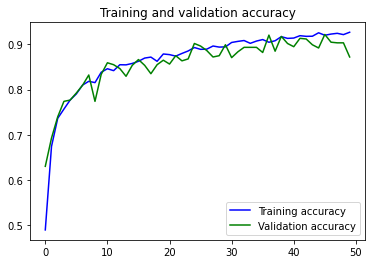

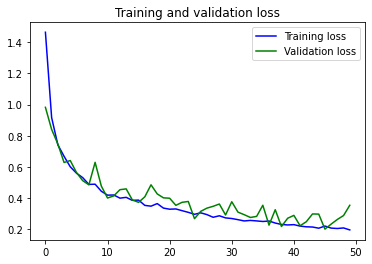

In [17]:
# plot the learning curves


epoch_num=PARAMS['n_epochs']
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(range(epoch_num), acc, 'b', label='Training accuracy')
plt.plot(range(epoch_num), val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(epoch_num), loss, 'b', label='Training loss')
plt.plot(range(epoch_num), val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [18]:
# evaluate model on *test* dataset

test_score = model.evaluate(test)
print(model.metrics_names)
print(test_score)
print()
print("Accuracy = ",test_score[1]*100,'%')

11/11 [==============================] - 2s 162ms/step - loss: 0.4150 - acc: 0.8608
['loss', 'acc']
[0.41495752334594727, 0.8607954382896423]

Accuracy =  86.07954382896423 %


## Transfer learning

We will use the VGG16 network (https://arxiv.org/abs/1409.1556) trained on the ImageNet dataset (http://image-net.org/about-overview).
As it is already part of the Keras library, it is easy to load.


In [19]:
# clear the prevoius session if needed
tensorflow.keras.backend.clear_session()

In [21]:
# Import VGG16
from tensorflow.keras.applications import VGG16

In [22]:
# Create a copy of the VGG16 network, with input_size to match our dataset, and without including the last output layer(s)
pretrained_net = VGG16(input_shape=(100,100,3),include_top=False,weights='imagenet',pooling='max')

KeyboardInterrupt: 

In [34]:
# Plot the summary of the pretrained network


### add code here

In [108]:
# 'Freeze' (i.e. make them untrainable) all layers in thre pretrained network
for layer in pretrained_net.layers:
    layer.trainable=False

In [110]:
# Add a couple of layers at the end of the pretrained network: we need to add our own output layer, 
# which will classify our data according to the number of classes we have.

model2 = models.Sequential()
model2.add(pretrained_net)
#model2.add(layers.Dense(256))
model2.add(layers.Dense(8, activation='softmax'))

In [111]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 8)                 4104      
Total params: 14,718,792
Trainable params: 4,104
Non-trainable params: 14,714,688
_________________________________________________________________


<font color='blue'> **Task 4:**
   
- Train the pretrained network (in reallity only the layers we added will be trained, we 'froze' all the layers previous to those) with the same data as before and compaire its performance to that of the previous model.
* Add code for plotting the learning curves for this model (you can also choose to overplot the learning curves of the previous model for direct comparison)
- Test the accuracty of the model on the 'test' dataset. </font>

In [112]:
# compile model 
model2.compile(loss=PARAMS['loss'],
              optimizer=optimizers.Adam(PARAMS['lr']),
              metrics=[PARAMS['metrics']])


### add code here

In [113]:
# Fit the model 
spe=len(train)   # train_size/batch_size
epoch_num=PARAMS['n_epochs']
val_steps=len(validation)  # validation_size/batch_size


history = model2.fit(
            train,
            steps_per_epoch=spe,  
            epochs=epoch_num,
            validation_data=validation,
            validation_steps=val_steps) 

### add code here

Epoch 1/25
33/33 [==============================] - 49s 1s/step - loss: 2.1873 - acc: 0.2738 - val_loss: 1.2007 - val_acc: 0.6947
Epoch 2/25
33/33 [==============================] - 48s 1s/step - loss: 1.0034 - acc: 0.7849 - val_loss: 0.7379 - val_acc: 0.8302
Epoch 3/25
33/33 [==============================] - 48s 1s/step - loss: 0.6516 - acc: 0.8685 - val_loss: 0.5553 - val_acc: 0.8688
Epoch 4/25
33/33 [==============================] - 48s 1s/step - loss: 0.5033 - acc: 0.8943 - val_loss: 0.4592 - val_acc: 0.8873
Epoch 5/25
33/33 [==============================] - 48s 1s/step - loss: 0.4139 - acc: 0.9145 - val_loss: 0.3991 - val_acc: 0.9030
Epoch 6/25
33/33 [==============================] - 48s 1s/step - loss: 0.3568 - acc: 0.9224 - val_loss: 0.3633 - val_acc: 0.9044
Epoch 7/25
33/33 [==============================] - 48s 1s/step - loss: 0.3089 - acc: 0.9283 - val_loss: 0.3268 - val_acc: 0.9130
Epoch 8/25
33/33 [==============================] - 48s 1s/step - loss: 0.2799 - acc: 0.93

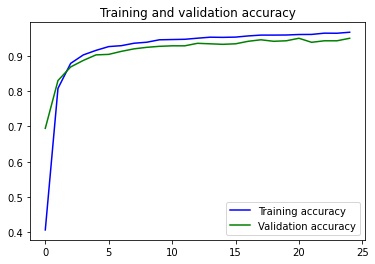

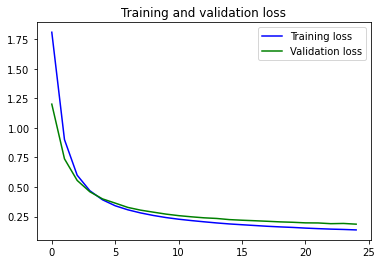

In [114]:
# plot learning curves
epoch_num=PARAMS['n_epochs']
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(range(epoch_num), acc, 'b', label='Training accuracy')
plt.plot(range(epoch_num), val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(epoch_num), loss, 'b', label='Training loss')
plt.plot(range(epoch_num), val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()
### add code here

In [ ]:
# test trained model on 'test' dataset

### add code here